# Policy Prediction

Gym environment uses pachi-py as the AI.

* Can we predict the the AI move from pachi?
* If so, can we used this to narrow down our MCTS search?

Assume:
* The game grid is 9x9
* There are only 9^2+1 moves. Resign terminals the episode. 

In [5]:
import gym
import numpy as np
import pachi_py
import time
import six
import os
import joblib
import time

import tensorflow as tf

from gym.envs.board_game.go import _coord_to_action, GoState, _action_to_coord

ENV_ID = 'Go9x9-v0'
WIDTH = HEIGH = 9
SHAPE = (WIDTH, HEIGH)
# Action 82 is resign

In [6]:
def roll_axis(ob):
    """ Change observations from CxHxW to HxWxC"""
    ob = np.swapaxes(ob, 0, 1)
    ob = np.swapaxes(ob, 1, 2)
    return ob

In [7]:
def get_legal_actions(board, color):
    """ Get the all black legal moves """
    cs = board.get_legal_coords(color)
    a = [_coord_to_action(board, c) for c in cs]
    return a

In [8]:
def make_pachi_policy(board, engine_type='uct', threads=1, pachi_timestr=''):
    engine = pachi_py.PyPachiEngine(board, engine_type, six.b('threads=%d' % threads))

    def pachi_policy(curr_state, prev_state, prev_action):
        if prev_state is not None:
            assert engine.curr_board == prev_state.board, 'Engine internal board is inconsistent with provided board. The Pachi engine must be called consistently as the game progresses.'
            prev_coord = _action_to_coord(prev_state.board, prev_action)
            engine.notify(prev_coord, prev_state.color)
            engine.curr_board.play_inplace(prev_coord, prev_state.color)
        out_coord = engine.genmove(curr_state.color, pachi_timestr)
        out_action = _coord_to_action(curr_state.board, out_coord)
        engine.curr_board.play_inplace(out_coord, curr_state.color)
        return out_action

    return pachi_policy

In [9]:
def sim_game(player):
    assert player in (pachi_py.BLACK, pachi_py.WHITE)
    enemy = pachi_py.stone_other(player)

    ob = []
    a = []

    state = GoState(pachi_py.CreateBoard(9), pachi_py.BLACK)
    player_policy = make_pachi_policy(board=state.board.clone(
    ), engine_type=six.b('uct'), pachi_timestr=six.b('_2400'))

    last_enemy_action = None
    last_state = None

    while not state.board.is_terminal:
        if state.color == player:
            ob.append(roll_axis(state.board.encode()))
            player_action = player_policy(state, last_state, last_enemy_action)
            a.append(player_action)
            state = state.act(player_action)
            assert state.color != player
            continue
        elif state.color == enemy:
            legal_actions = get_legal_actions(state.board, enemy)
            last_enemy_action = np.random.choice(legal_actions)
            last_state = state
            state = state.act(last_enemy_action)
            continue
        else:
            raise NotImplementedError

    return ob, a, [player-1 for _ in a]

In [10]:
def sim_batch(n):
    """ Randomly Simulate n number of games """
    ob_batch = []
    a_batch = []
    p_batch = []
    for i in range(n):
        p = np.random.choice((pachi_py.BLACK, pachi_py.WHITE))
        ob, a, p = sim_game(p)
        ob_batch += ob
        a_batch += a
        p_batch += p
    ob_batch = np.stack(ob_batch)
    a_batch = np.stack(a_batch)
    p_batch = np.stack(p_batch).reshape((-1, 1))
    
    return ob_batch, a_batch, p_batch

# Generate some games

In [ ]:
tic = time.time()
# ob_train, a_train, p_train = sim_batch(10)
ob_test, a_test, p_test = sim_batch(64)
toc = time.time() - tic
s = ob_test.shape[0]
print('Total: {:.2f}s {:.2f}ms per step'.format(toc, 100*toc/s))
# for 1000 training loops this will take 100 minutes
# might have to generate data first to save on training time

In [ ]:
print(ob_test.shape)
print(a_test.shape)
print(p_test.shape)

In [ ]:
symmetry = {
    'identity': lambda x: x,
    'rot90': np.rot90,
    'rot180': lambda x: np.rot90(x, k=2),
    'rot270': lambda x: np.rot90(x, k=3),
    'flip': lambda x: np.rot90(np.fliplr(x)),
    'fliprot90': np.flipud,
    'fliprot180': lambda x: np.rot90(np.flipud(x)),
    'fliprot270': np.fliplr,
}

# TensorFlow

In [9]:
def residual_block(inputs):
    conv_1 = tf.layers.conv2d(inputs, filters=256, kernel_size=3, activation=tf.nn.relu, padding='SAME')
    conv_2 = tf.layers.conv2d(conv_1, filters=256, kernel_size=3, padding='SAME')
    return tf.nn.relu(conv_2 + inputs)

In [12]:
N_CHANNELS = 3

tf.reset_default_graph()

global_step = tf.Variable(0, trainable=False)

ob_ph = tf.placeholder(tf.float32, [None, WIDTH, HEIGH, N_CHANNELS])
p_ph = tf.placeholder(tf.float32, [None, 1])
a_ph = tf.placeholder(tf.int64, [None])

player_channel = p_ph * tf.ones([1, HEIGH], dtype=tf.float32)
player_channel = tf.expand_dims(player_channel, -1)
player_channel = player_channel * tf.ones([1, HEIGH, WIDTH], dtype=tf.float32)
player_channel = tf.expand_dims(player_channel, -1)


obp = tf.concat((ob_ph, player_channel), 3)

# Single Convolutional Block
conv_1 = tf.layers.conv2d(obp, filters=256, kernel_size=3, activation=tf.nn.relu, padding='SAME')

# Residual blocks
prev = conv_1

for i in range(19):
    res = residual_block(conv_1)
    prev = res
    
# Policy head
conv_2 = tf.layers.conv2d(prev, filters=2, kernel_size=1, activation=tf.nn.relu, padding='SAME')
conv_2_flat = tf.layers.flatten(conv_2)
pi = tf.layers.dense(conv_2_flat, 9*9+1)


a_pred = tf.argmax(pi, axis=1)
correct_pred = tf.equal(tf.argmax(pi,1), a_ph)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('classification_accuracy', accuracy)

obj = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pi, labels=a_ph)
pg_loss = tf.reduce_mean(obj)

tf.summary.scalar('policy_loss', pg_loss)
tf.summary.scalar('global_step', global_step)

optimiser = tf.train.AdamOptimizer(1e-4)
train_op = optimiser.minimize(pg_loss, global_step=global_step)

merged_summary = tf.summary.merge_all()
global_init_op = tf.global_variables_initializer()
local_init_op = tf.local_variables_initializer()

In [16]:
fresh_date = False

tb_path = 'tb'
session_id = time.strftime('%Y-%m-%dT%H:%M:%S')
train_tb = os.path.join(tb_path, session_id, 'TRAIN')
train_writer = tf.summary.FileWriter(train_tb)

test_tb = os.path.join(tb_path,session_id, 'TEST')
test_writer = tf.summary.FileWriter(test_tb)

test_dict = {ob_ph:ob_test, p_ph: p_test, a_ph:a_test}

saver = tf.train.Saver()

sess = tf.InteractiveSession()
train_writer.add_graph(sess.graph)
global_init_op.run()
local_init_op.run()


data_files = files = os.listdir('batch/')
local_idx = 0



for i in range(1500):
    
    if local_idx < len(data_files) and not fresh_date:
        (batch_ob, batch_a, batch_p) = joblib.load(os.path.join('batch',  data_files[local_idx]))
        local_idx+=1
    else:
        batch_ob, batch_a, batch_p = sim_batch(3)
        joblib.dump((batch_ob, batch_a, batch_p), os.path.join('batch', str(int(time.time()))+ '.dat'))
        
    batch_dict = {ob_ph:batch_ob, p_ph: batch_p, a_ph:batch_a}
    
    # record in tb
    train_summary, gs = sess.run([merged_summary, global_step], feed_dict=batch_dict)
    train_writer.add_summary(train_summary, gs)
    train_writer.flush()
            
    test_summary, gs = sess.run([merged_summary, global_step], feed_dict=test_dict)
    test_writer.add_summary(test_summary, gs)
    test_writer.flush()
    
    
    for j in range(20):
        train_op.run(feed_dict=batch_dict)

train_writer.close()       
test_writer.close()

print('INFO: model saved: {}'.format(saver.save(sess, 'model/ckpt')))

INFO: model saved: model/ckpt


# Test Accuracy

In [18]:
test_pi = pi.eval(feed_dict=test_dict)
test_pred = np.argmax(test_pi, axis=1)
correct = np.equal(test_pred, a_test).astype(np.int32)
accuracy = np.mean(correct)
print('Test Accuracy: {:.2f}%'.format(100*accuracy))

Test Accuracy: 21.14%


# Simulate Some Games

In [56]:
def sim_game(player):
    assert player in (pachi_py.BLACK, pachi_py.WHITE)
    enemy = pachi_py.stone_other(player)

    ob = []
    a = []

    state = GoState(pachi_py.CreateBoard(9), pachi_py.BLACK)
    player_policy = make_pachi_policy(board=state.board.clone(
    ), engine_type=six.b('uct'), pachi_timestr=six.b('_2400'))

    last_enemy_action = None
    last_state = None

    while not state.board.is_terminal:
        if state.color == player:
            ob.append(roll_axis(state.board.encode()))
            player_action = player_policy(state, last_state, last_enemy_action)
            a.append(player_action)
            state = state.act(player_action)
            assert state.color != player
            continue
        elif state.color == enemy:
            p = sess.run(pi, feed_dict={ob_ph:[roll_axis(state.board.encode())], p_ph:np.asarray([enemy]).reshape((-1, 1))})
            a_s = np.argsort(p)[0][::-1]
            legal_actions = get_legal_actions(state.board, enemy)
            i = 0
            while i <len(a_s):
                if a_s[i] in legal_actions:
                    last_enemy_action  = a_s[i]
                    break
                else:
                    i+=1
            last_state = state
            state = state.act(last_enemy_action)
            continue
        else:
            raise NotImplementedError

    return ob, a, [player-1 for _ in a], state

In [73]:
ob, a, p, s= sim_game(pachi_py.BLACK)
print(s.board.official_score)
s

-41.0


To play: white
Move:  89  Komi: 0.0  Handicap: 0  Captures B: 31 W: 8
      A B C D E F G H J  
    +-------------------+
  9 | . X . X . X X X . |
  8 | . . X . X . X X . |
  7 | . X . X . X X . X |
  6 | X X X X . X . X O |
  5 | . X X . X X X O . |
  4 | . O . . X . X O O |
  3 | . . O . X X X X O |
  2 | . O X X X . X O O |
  1 | . O X . . X O . O |
    +-------------------+

In [74]:
p = sess.run(pi, feed_dict={ob_ph:[roll_axis(state.board.encode())], p_ph:np.asarray([enemy]).reshape((-1, 1))})

In [86]:
noise = np.random.uniform(size=(82))
sample = p - np.log(-np.log(noise))

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
p.shape

(1, 82)

<Container object of 82 artists>

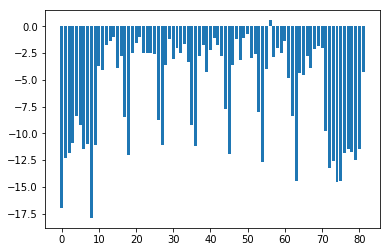

In [85]:
plt.bar(range(82), p[0])

<Container object of 82 artists>

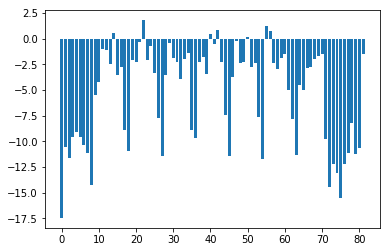

In [88]:
plt.bar(range(82), sample[0])